In [1]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import tensorflow.keras.callbacks as tfcb
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score,recall_score,f1_score

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import json
import yaml
import pathlib
from time import time

import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
modelYamlDir='./model_yaml/'
modelH5Dir='./model_h5/'
modelPbDir='./model_pb/model_mobilenet/'
modelLiteDir='./model_lite/model_mobilenet/'
datasetDir='./datasets/Germinated Oil Palm Seeds/'
TFRecordPath=datasetDir+'dataset.tfrecords'

os.makedirs(modelYamlDir) if not os.path.exists(modelYamlDir) else None
os.makedirs(modelH5Dir) if not os.path.exists(modelH5Dir) else None
os.makedirs(modelPbDir) if not os.path.exists(modelPbDir) else None
os.makedirs(modelLiteDir) if not os.path.exists(modelLiteDir) else None

In [3]:
def store_model_parameter(model):
    jsonString=model.to_json()
    yamlString=yaml.dump(json.loads(jsonString))
    with open('./model_yaml/model_mobilenet.yaml','w') as modelYaml:
        modelYaml.write(yamlString)
    model.save_weights('./model_h5/model_mobilenet.h5')
    print('model structure and weight has been stored separately')

def restore_model_parameter():
    with open('./model_yaml/model_mobilenet.yaml') as yamlString:
        modelYaml=yamlString.read()
    modelJson=json.dumps(yaml.safe_load(modelYaml))
    restoredModel=tf.keras.models.model_from_json(modelJson)
    restoredModel.load_weights('./model_h5/model_mobilenet.h5')
    restoredModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print('model structure and weight has been restored')
    return restoredModel

In [4]:
TFRecordFeature={'image':tf.io.FixedLenFeature([],tf.string),
                 'label':tf.io.FixedLenFeature([],tf.int64)}

def store_TFRecord(datasetDir,TFRecordPath):
    goodDatasetDir=datasetDir+'GOOD/'
    badDatasetDir=datasetDir+'BAD/'
    goodDatasetPath=[goodDatasetDir+filename for filename in os.listdir(goodDatasetDir)]
    badDatasetPath=[badDatasetDir+filename for filename in os.listdir(badDatasetDir)]
    datasetPath=goodDatasetPath+badDatasetPath
    datasetLabel=[1]*len(goodDatasetPath)+[0]*len(badDatasetPath)

    with tf.io.TFRecordWriter(TFRecordPath) as TFRecordWriter:
        for path,label in zip(datasetPath,datasetLabel):
            imageByteList=open(path,'rb').read()
            TFRecordFeature={'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[imageByteList])),
                             'label':tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))}
            TFRecordExample=tf.train.Example(features=tf.train.Features(feature=TFRecordFeature))
            TFRecordWriter.write(TFRecordExample.SerializeToString())
    print('TFRecord has been created and stored')

def parse_TFRecord(exampleString):
    featureDict=tf.io.parse_single_example(exampleString,TFRecordFeature)
    featureDict['image']=tf.io.decode_jpeg(featureDict['image'])
    featureDict['image']=tf.image.resize(featureDict['image'],[224,224])/255.0
    return featureDict['image'],featureDict['label']

def restore_TFRecord(TFRecordPath):
    restoredDataset=tf.data.TFRecordDataset(TFRecordPath)
    restoredDataset=restoredDataset.map(parse_TFRecord)
    print('TFRecord has been restored and used')
    return restoredDataset

##### 0.1 load dataset

In [5]:
if not os.path.isfile(TFRecordPath):
    print('TFRecord does not exist, creating for next time use')
    store_TFRecord(datasetDir,TFRecordPath)
    dataset=restore_TFRecord(TFRecordPath)
else:
    print('TFRecord found, restoring for use this time')
    dataset=restore_TFRecord(TFRecordPath)
    
dataset=dataset.shuffle(4000)
trainDataset=dataset.take(3000)
trainDataset=trainDataset.prefetch(tf.data.experimental.AUTOTUNE)
testDataset=dataset.skip(3000)

TFRecord found, restoring for use this time
TFRecord has been restored and used


In [6]:
trainDatasetNum=0
for _ in trainDataset:
    trainDatasetNum+=1
print("Number of sample in train dataset is:", trainDatasetNum)
print("Number of sample in test dataset is:", 4000-trainDatasetNum)

Number of sample in train dataset is: 3000
Number of sample in test dataset is: 1000


shape of sample dataset: (224, 224, 3) , shape of sample label: ()


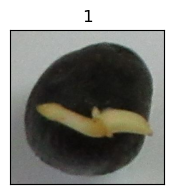

In [7]:
sampleDataset=trainDataset.take(1)
for sampleFeature,sampleLabel in sampleDataset:
    print('shape of sample dataset:',sampleFeature.shape,', shape of sample label:',sampleLabel.shape)
    plt.figure(figsize=(2,2)) 
    plt.title(sampleLabel.numpy())
    plt.xticks([])
    plt.yticks([])
    plt.imshow(sampleFeature.numpy())
    plt.show()

shape of batched dataset: (200, 224, 224, 3) , shape of dataset label: (200,)


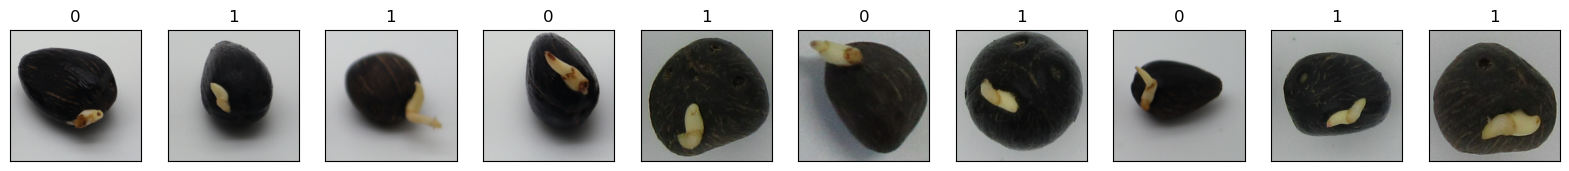

In [8]:
trainDatasetIter=iter(trainDataset.batch(200))
feature,label=next(trainDatasetIter)
print('shape of batched dataset:',feature.shape,', shape of dataset label:',label.shape)

fig,axs=plt.subplots(1,10,figsize=(20,2))
for i in range(10):
    axs[i].set_title(label.numpy()[i])
    axs[i].imshow(feature.numpy()[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

##### 0.2 train a model based on mobile net

In [9]:
mobileNet=tf.keras.applications.mobilenet.MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))
for layer in mobileNet.layers:
    layer.trainable=False

mobileNetOutputLayer=mobileNet.output
newOutputLayer=tf.keras.layers.Flatten()(mobileNetOutputLayer)
newOutputLayer=tf.keras.layers.Dense(128,activation='relu')(newOutputLayer)
newOutputLayer=tf.keras.layers.Dropout(0.3)(newOutputLayer)
newOutputLayer=tf.keras.layers.Dense(32,activation='relu')(newOutputLayer)
newOutputLayer=tf.keras.layers.Dropout(0.3)(newOutputLayer)
newOutputLayer=tf.keras.layers.Dense(2,activation='softmax')(newOutputLayer)

model=tf.keras.models.Model(inputs=mobileNet.input,outputs=newOutputLayer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [10]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.950):
            print('\nModel accuracy is enough so training will stop')
            self.model.stop_training=True

callbacks=stop_training_callback()

In [11]:
if os.path.isfile(modelYamlDir+'model_mobilenet.yaml') and os.path.isfile(modelH5Dir+'model_mobilenet.h5'):
    print('trained model found, restoring the parameter')
    model=restore_model_parameter()
else:
    print('trained model not found, training the model')
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    epochs=200
    model.fit(trainDataset.batch(200),epochs=epochs,verbose=1,callbacks=[callbacks])
    store_model_parameter(model)

trained model found, restoring the parameter
model structure and weight has been restored


##### 0.3 prepare for model optimization

In [12]:
def run_model(model):
    startTime=time()
    loss,accuracy=model.evaluate(testDataset.batch(1))
    print('test dataset finished takes: {:.4f}'.format(time()-startTime))
    print('Model accuracy is {:.4f}%, model loss is {:.4f}%'.format(accuracy*100,loss*100))

def run_tflite_model(model,dataset):
    TFLiteInterpreter=tf.lite.Interpreter(model_content=model)
    TFLiteInterpreter.allocate_tensors()

    inputDetail=TFLiteInterpreter.get_input_details()
    outputDetail=TFLiteInterpreter.get_output_details()
    inputIndex=inputDetail[0]['index']
    outputIndex=outputDetail[0]['index']

    testPrediction=[]
    testLabel=[]
    startTime=time()
    for image,label in dataset:
        inputData=tf.expand_dims(image,0)
        TFLiteInterpreter.set_tensor(inputIndex,inputData)
        TFLiteInterpreter.invoke()
        outputData=TFLiteInterpreter.get_tensor(outputIndex)

        prediction=tf.argmax(outputData,axis=1)[0]
        testPrediction.append(prediction)
        testLabel.append(label.numpy())
    print('test dataset finished takes: {:.4f} s'.format(time()-startTime))

    correctPredictions=tf.equal(testPrediction,testLabel)
    accuracy=tf.reduce_mean(tf.cast(correctPredictions, tf.float32))
    print('TF lite model Accuracy: {:.4f}%'.format(accuracy*100))
    
    return testPrediction,testLabel
    
def show_model_metrics(prediction,label):
    prediction=np.array(prediction)
    label=np.array(label)

    testPrecision=precision_score(label,prediction,average='weighted')
    testRecall=recall_score(label,prediction,average='weighted')
    testF1=f1_score(label,prediction,average='weighted')

    print("model precision: {:.2f}%".format(testPrecision*100))
    print("model recall: {:.2f}%".format(testRecall*100))
    print("model f1-score: {:.2f}%".format(testF1*100))

In [19]:
def convert_save_run_TFLite(model,path,dataset):
    TFLiteConverter=tf.lite.TFLiteConverter.from_keras_model(model)
    TFLiteModel=TFLiteConverter.convert()
    
    pathlib.Path(modelLiteDir+path).write_bytes(TFLiteModel)
    testPrediction,testLabel=run_tflite_model(TFLiteModel,dataset)
    show_model_metrics(testPrediction,testLabel)
    TFLiteModelSize=os.path.getsize(modelLiteDir+path)/(1024*1024)
    print('TF Lite model size: {:.1f} MB'.format(TFLiteModelSize))

def convert_save_run_TFLite_dynamic_range_quantized(model,path,dataset):
    TFLiteConverter=tf.lite.TFLiteConverter.from_keras_model(model)
    TFLiteConverter.optimizations=[tf.lite.Optimize.DEFAULT]
    TFLiteModel=TFLiteConverter.convert()

    pathlib.Path(modelLiteDir+path).write_bytes(TFLiteModel)
    testPrediction,testLabel=run_tflite_model(TFLiteModel,dataset)
    show_model_metrics(testPrediction,testLabel)
    TFLiteModelSize=os.path.getsize(modelLiteDir+path)/(1024*1024)
    print('TF Lite model size: {:.1f} MB'.format(TFLiteModelSize))

def convert_save_run_TFLite_INT8_quantized(model,path,dataset):
    TFLiteConverter=tf.lite.TFLiteConverter.from_keras_model(model)
    TFLiteConverter.optimizations=[tf.lite.Optimize.DEFAULT]
    def representative_dataset_generator():
        for image,label in testDataset.batch(1).take(100):
            yield [image]
    TFLiteConverter.representative_dataset=representative_dataset_generator
    TFLiteConverter.target_spec.supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    TFLiteModel=TFLiteConverter.convert()

    pathlib.Path(modelLiteDir+path).write_bytes(TFLiteModel)
    testPrediction,testLabel=run_tflite_model(TFLiteModel,dataset)
    show_model_metrics(testPrediction,testLabel)
    TFLiteModelSize=os.path.getsize(modelLiteDir+path)/(1024*1024)
    print('TF Lite model size: {:.1f} MB'.format(TFLiteModelSize))

def convert_save_run_TFLite_FLOAT16_quantized(model,path,dataset):
    TFLiteConverter=tf.lite.TFLiteConverter.from_keras_model(model)
    TFLiteConverter.optimizations=[tf.lite.Optimize.DEFAULT]
    TFLiteConverter.target_spec.supported_types=[tf.float16]
    TFLiteModel=TFLiteConverter.convert()

    pathlib.Path(modelLiteDir+path).write_bytes(TFLiteModel)
    testPrediction,testLabel=run_tflite_model(TFLiteModel,dataset)
    show_model_metrics(testPrediction,testLabel)
    TFLiteModelSize=os.path.getsize(modelLiteDir+path)/(1024*1024)
    print('TF Lite model size: {:.1f} MB'.format(TFLiteModelSize))

In [14]:
def plot_pruned_layer(path,name):
    TFLiteInterpreter=tf.lite.Interpreter(modelLiteDir+path)
    TFLiteInterpreter.allocate_tensors()
    tensorDetail=TFLiteInterpreter.get_tensor_details()

    tensorName=name
    detail=[x for x in tensorDetail if tensorName in x["name"]]
    tensorData=TFLiteInterpreter.tensor(detail[0]["index"])()

    width,height=64,48
    tensorToDisplay=tensorData[0:height,0:width]
    tensorToDisplay=np.where(abs(tensorToDisplay)>0,np.ones([height,width]),np.zeros([height,width]))

    blockSize=[1,4]
    numberOfHorizontalLine=int((height-1)/blockSize[0])
    numberOfVerticalLine=int((width-1)/blockSize[1])
    horizontalLinePosition=[y*blockSize[0] for y in range(1,numberOfHorizontalLine+1)]
    numberOfVerticalLine=[x*blockSize[1] for x in range(1,numberOfVerticalLine+1)]
    [plt.plot([-0.5,width],[i-0.5,i-0.5],color='w') for i in horizontalLinePosition]
    [plt.plot([i-0.5,i-0.5],[-0.5,height],color='w') for i in numberOfVerticalLine]

    plt.axis('off')
    plt.imshow(tensorToDisplay)
    plt.title("weights in the pruned dense layer")
    plt.show()

##### 1.1 baseline

In [15]:
run_model(model)
tf.saved_model.save(model,modelPbDir)
print('model has been saved to:',modelPbDir)

1000/1000 [==============================] - 5s 2ms/step - loss: 0.0618 - accuracy: 0.9800
test dataset finished takes: 4.7720
Model accuracy is 98.0000%, model loss is 6.1793%


model has been saved to: ./model_pb/model_mobilenet/


##### 1.2.1 baseline - TF Lite

In [16]:
convert_save_run_TFLite(model,'model_mobilenet.tflite',testDataset.take(200))

test dataset finished takes: 3.8735 s
TF lite model Accuracy: 97.0000%
model precision: 97.16%
model recall: 97.00%
model f1-score: 96.99%
TF Lite model size: 36.7 MB


##### 1.2.2 baseline - dynamic range quantized TF Lite

In [17]:
convert_save_run_TFLite_dynamic_range_quantized(model,'model_mobilenet_dynamic_range_quantized.tflite',testDataset.take(200))

test dataset finished takes: 19.4850 s
TF lite model Accuracy: 92.5000%
model precision: 93.44%
model recall: 92.50%
model f1-score: 92.43%
TF Lite model size: 9.4 MB


##### 1.2.3 baseline - INT8 quantized TF Lite

In [20]:
convert_save_run_TFLite_INT8_quantized(model,'model_mobilenet_INT8_quantized.tflite',testDataset.take(200))

test dataset finished takes: 13.3595 s
TF lite model Accuracy: 88.5000%
model precision: 90.42%
model recall: 88.50%
model f1-score: 88.12%
TF Lite model size: 9.5 MB


##### 1.2.4 baseline - FLOAT16 quantized TF Lite

In [21]:
convert_save_run_TFLite_FLOAT16_quantized(model,'model_mobilenet_FLOAT16_quantized.tflite',testDataset.take(200))

test dataset finished takes: 4.0530 s
TF lite model Accuracy: 97.5000%
model precision: 97.54%
model recall: 97.50%
model f1-score: 97.50%
TF Lite model size: 18.4 MB


In [22]:
learningRateCallback=tf.keras.callbacks.LearningRateScheduler(lambda epoch:0.00002 if epoch<10 else 0.00001)

class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.98):
            print('\nModel accuracy is enough so training will stop')
            self.model.stop_training=True
stopTrainingCallback=stop_training_callback()

In [23]:
randomPruningParameter={'pruning_schedule':tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5,begin_step=0,frequency=100)}
pruningParameter={'sparsity_m_by_n':(2,4)}

modelStructuralPruned=restore_model_parameter()
modelStructuralPruned.layers[1]=tfmot.sparsity.keras.prune_low_magnitude(modelStructuralPruned.layers[1],**randomPruningParameter)
for i in range(2,len(modelStructuralPruned.layers)):
    if isinstance(modelStructuralPruned.layers[i],(tf.keras.layers.Conv2D,tf.keras.layers.Dense)):
        modelStructuralPruned.layers[i]=tfmot.sparsity.keras.prune_low_magnitude(modelStructuralPruned.layers[i],**pruningParameter)

modelStructuralPruned.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

modelStructuralPruned.fit(trainDataset.take(2000).batch(1),epochs=50,callbacks=[tfmot.sparsity.keras.UpdatePruningStep(),learningRateCallback,stopTrainingCallback])

model structure and weight has been restored
Epoch 1/50
2000/2000 [==============================] - 6s 2ms/step - loss: 0.0954 - accuracy: 0.9650 - lr: 2.0000e-05
Epoch 2/50
2000/2000 [==============================] - 5s 2ms/step - loss: 0.0779 - accuracy: 0.9720 - lr: 2.0000e-05
Epoch 3/50
2000/2000 [==============================] - 5s 2ms/step - loss: 0.0672 - accuracy: 0.9760 - lr: 2.0000e-05
Epoch 4/50
1986/2000 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9809
Model accuracy is enough so training will stop
2000/2000 [==============================] - 5s 2ms/step - loss: 0.0574 - accuracy: 0.9810 - lr: 2.0000e-05


##### 2.1 structural pruned

In [24]:
run_model(modelStructuralPruned)
modelStructuralPruned=tfmot.sparsity.keras.strip_pruning(modelStructuralPruned)
print('pruning wrapper has been removed form model before converting to TF Lite')

1000/1000 [==============================] - 3s 2ms/step - loss: 0.0179 - accuracy: 0.9970
test dataset finished takes: 2.8816
Model accuracy is 99.7000%, model loss is 1.7925%
pruning wrapper has been removed form model before converting to TF Lite


##### 2.2.1 structural pruned - TF lite

test dataset finished takes: 4.0288 s
TF lite model Accuracy: 99.5000%
model precision: 99.51%
model recall: 99.50%
model f1-score: 99.50%
TF Lite model size: 36.7 MB


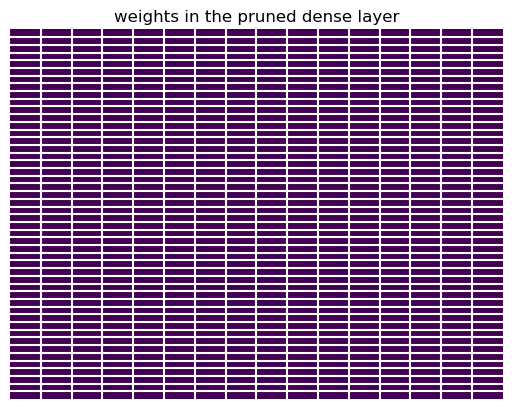

In [25]:
convert_save_run_TFLite(modelStructuralPruned,'model_mobilenet_structural_pruned.tflite',testDataset.take(200))
plot_pruned_layer('model_mobilenet_structural_pruned.tflite','dense/MatMul')

##### 2.2.2 structural pruned - dynamic range quantized TF Lite

In [26]:
convert_save_run_TFLite_dynamic_range_quantized(modelStructuralPruned,'model_mobilenet_structural_pruned_dynamic_range_quantized.tflite',testDataset.take(200))

test dataset finished takes: 19.9248 s
TF lite model Accuracy: 99.0000%
model precision: 99.00%
model recall: 99.00%
model f1-score: 99.00%
TF Lite model size: 9.4 MB


##### 2.2.3 structural pruned - INT8 quantized TF Lite

In [27]:
convert_save_run_TFLite_INT8_quantized(modelStructuralPruned,'model_mobilenet_structural_pruned_INT8_quantized.tflite',testDataset.take(200))

test dataset finished takes: 13.5516 s
TF lite model Accuracy: 94.0000%
model precision: 94.48%
model recall: 94.00%
model f1-score: 94.01%
TF Lite model size: 9.5 MB


##### 2.2.4 structural pruned - FLOAT16 quantized TF Lite

In [28]:
convert_save_run_TFLite_FLOAT16_quantized(modelStructuralPruned,'model_mobilenet_structural_pruned_FLOAT16_quantized.tflite',testDataset.take(200))

test dataset finished takes: 4.1653 s
TF lite model Accuracy: 99.0000%
model precision: 99.02%
model recall: 99.00%
model f1-score: 99.00%
TF Lite model size: 18.4 MB


In [29]:
class UnstructuralPruningCallback(tfcb.Callback):
    def __init__(self,final_sparsity,begin_step):
        super().__init__()
        self.final_sparsity=final_sparsity
        self.begin_step=begin_step

    def on_epoch_end(self,epoch,logs=None):
        if epoch>self.begin_step:
            weight=self.model.get_weights()
            weightFlattened=np.concatenate([w.flatten() for w in weight])
            sortedIndex=np.argsort(np.abs(weightFlattened))
            numberToPrune=int(self.final_sparsity*len(sortedIndex))
            weightFlattened[sortedIndex[:numberToPrune]]=0.0

            currentIndex=0
            for i,w in enumerate(weight):
                originalShape=w.shape
                originalSize=np.prod(originalShape)
                weight[i]=weightFlattened[currentIndex:currentIndex+originalSize].reshape(originalShape)
                currentIndex+=originalSize
                
            self.model.set_weights(weight)

pruning_callback=UnstructuralPruningCallback(final_sparsity=0.5,begin_step=10)
modelUnstructuralPruned=restore_model_parameter()
modelUnstructuralPruned.fit(trainDataset.take(2000).batch(200),epochs=50,callbacks=[pruning_callback,stopTrainingCallback])

model structure and weight has been restored
Epoch 1/50
10/10 [==============================] - 3s 71ms/step - loss: 0.5797 - accuracy: 0.8180
Epoch 2/50
10/10 [==============================] - 1s 60ms/step - loss: 0.3647 - accuracy: 0.8430
Epoch 3/50
10/10 [==============================] - 1s 60ms/step - loss: 0.2116 - accuracy: 0.9295
Epoch 4/50
10/10 [==============================] - 1s 65ms/step - loss: 0.1742 - accuracy: 0.9420
Epoch 5/50
10/10 [==============================] - 1s 60ms/step - loss: 0.1246 - accuracy: 0.9545
Epoch 6/50
10/10 [==============================] - 1s 64ms/step - loss: 0.0866 - accuracy: 0.9675
Epoch 7/50
10/10 [==============================] - 2s 61ms/step - loss: 0.0758 - accuracy: 0.9715
Epoch 8/50
10/10 [==============================] - 1s 61ms/step - loss: 0.0644 - accuracy: 0.9775
Epoch 9/50
10/10 [==============================] - 2s 62ms/step - loss: 0.0788 - accuracy: 0.9710
Epoch 10/50
10/10 [==============================] - 1s 61ms/ste

##### 3.1 unstructural pruned

In [30]:
run_model(modelUnstructuralPruned)
modelUnstructuralPruned=tfmot.sparsity.keras.strip_pruning(modelUnstructuralPruned)
print('pruning wrapper has been removed form model before converting to TF Lite')

1000/1000 [==============================] - 3s 2ms/step - loss: 0.0117 - accuracy: 0.9960
test dataset finished takes: 3.4793
Model accuracy is 99.6000%, model loss is 1.1714%
pruning wrapper has been removed form model before converting to TF Lite


##### 3.2.1 unstructural pruned - TF lite

test dataset finished takes: 4.5377 s
TF lite model Accuracy: 100.0000%
model precision: 100.00%
model recall: 100.00%
model f1-score: 100.00%
TF Lite model size: 36.7 MB


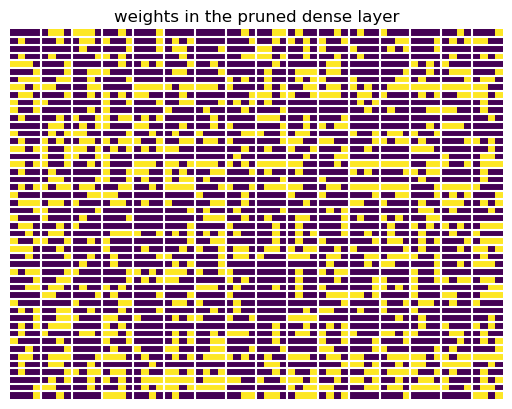

In [31]:
convert_save_run_TFLite(modelUnstructuralPruned,'model_mobilenet_unstructural_pruned.tflite',testDataset.take(200))
plot_pruned_layer('model_mobilenet_unstructural_pruned.tflite','dense/MatMul')

##### 3.2.2 unstructured pruned - dynamic range quantized TF lite

In [32]:
convert_save_run_TFLite_dynamic_range_quantized(modelUnstructuralPruned,'model_mobilenet_unstructural_pruned_dynamic_range_quantized.tflite',testDataset.take(200))

test dataset finished takes: 20.3327 s
TF lite model Accuracy: 99.0000%
model precision: 99.00%
model recall: 99.00%
model f1-score: 99.00%
TF Lite model size: 9.4 MB


##### 3.2.3 unstructured pruned - INT8 quantized TF lite

In [33]:
convert_save_run_TFLite_INT8_quantized(modelUnstructuralPruned,'model_mobilenet_unstructural_pruned_INT8_quantized.tflite',testDataset.take(200))

test dataset finished takes: 13.8981 s
TF lite model Accuracy: 93.0000%
model precision: 93.10%
model recall: 93.00%
model f1-score: 93.01%
TF Lite model size: 9.5 MB


##### 3.2.4 unstructured pruned - FLOAT16 quantized TF lite

In [34]:
convert_save_run_TFLite_FLOAT16_quantized(modelUnstructuralPruned,'model_mobilenet_unstructural_pruned_FLOAT16_quantized.tflite',testDataset.take(200))

test dataset finished takes: 4.5037 s
TF lite model Accuracy: 99.0000%
model precision: 99.02%
model recall: 99.00%
model f1-score: 99.00%
TF Lite model size: 18.4 MB


In [35]:
class Distiller(tf.keras.Model):
    def __init__(self,student,teacher):
        super().__init__()
        self.teacher=teacher
        self.student=student

    def compile(self,
                optimizer,
                metrics,
                student_loss_fn,
                distillation_loss_fn,
                alpha=0.1,
                temperature=3):
                
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn=student_loss_fn
        self.distillation_loss_fn=distillation_loss_fn
        self.alpha=alpha
        self.temperature=temperature

    def train_step(self,data):
        x,y=data
        teacher_predictions=self.teacher(x,training=False)
        with tf.GradientTape() as tape:
            student_predictions=self.student(x,training=True)
            student_loss=self.student_loss_fn(y,student_predictions)
            distillation_loss=(self.distillation_loss_fn(tf.nn.softmax(teacher_predictions/self.temperature,axis=1),
                                                         tf.nn.softmax(student_predictions/self.temperature,axis=1))*self.temperature**2)
            loss=self.alpha*student_loss+(1-self.alpha)*distillation_loss
        trainable_vars=self.student.trainable_variables
        gradients=tape.gradient(loss,trainable_vars)
        self.optimizer.apply_gradients(zip(gradients,trainable_vars))
        self.compiled_metrics.update_state(y,student_predictions)
        results={m.name: m.result() for m in self.metrics}
        results.update({"student_loss":student_loss,"distillation_loss":distillation_loss})
        return results

    def test_step(self,data):
        x,y=data
        y_prediction=self.student(x,training=False)
        student_loss=self.student_loss_fn(y,y_prediction)
        self.compiled_metrics.update_state(y,y_prediction)
        results={m.name: m.result() for m in self.metrics}
        results.update({"student_loss":student_loss})
        return results

In [36]:
def create_student_model():
    inputLayer=tf.keras.layers.Input(shape=(224,224,3))
    newOutputLayer=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(inputLayer)
    newOutputLayer=tf.keras.layers.MaxPooling2D((2,2))(newOutputLayer)
    newOutputLayer=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(newOutputLayer)
    newOutputLayer=tf.keras.layers.MaxPooling2D((2,2))(newOutputLayer)
    newOutputLayer=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(newOutputLayer)
    newOutputLayer=tf.keras.layers.MaxPooling2D((2,2))(newOutputLayer)
    newOutputLayer=tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same')(newOutputLayer)
    newOutputLayer=tf.keras.layers.MaxPooling2D((2,2))(newOutputLayer)
    newOutputLayer=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(newOutputLayer)
    newOutputLayer=tf.keras.layers.MaxPooling2D((2,2))(newOutputLayer)
    newOutputLayer=tf.keras.layers.Flatten()(newOutputLayer)
    newOutputLayer=tf.keras.layers.Dense(128,activation='relu')(newOutputLayer)
    newOutputLayer=tf.keras.layers.Dropout(0.3)(newOutputLayer)
    newOutputLayer=tf.keras.layers.Dense(64,activation='relu')(newOutputLayer)
    newOutputLayer=tf.keras.layers.Dropout(0.3)(newOutputLayer)
    outputLayer=tf.keras.layers.Dense(2,activation='softmax')(newOutputLayer)

    model=tf.keras.models.Model(inputs=inputLayer, outputs=outputLayer)
    return model
    
modelTeacher=restore_model_parameter()
modelStudent=create_student_model()

model structure and weight has been restored


In [37]:
modelTeacher.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
modelTeacher.fit(trainDataset.take(2000).batch(200),epochs=10,verbose=1)

distiller=Distiller(student=modelStudent,teacher=modelTeacher)
distiller.compile(optimizer=tf.keras.optimizers.Adam(),
                  student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  distillation_loss_fn=tf.keras.losses.KLDivergence(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
                  alpha=0.1,
                  temperature=10)

distiller.fit(trainDataset.take(2000).batch(200),epochs=50,verbose=1)

Epoch 1/10
10/10 [==============================] - 3s 73ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.9050
Epoch 2/10
10/10 [==============================] - 2s 67ms/step - loss: 0.1367 - sparse_categorical_accuracy: 0.9450
Epoch 3/10
10/10 [==============================] - 2s 62ms/step - loss: 0.1439 - sparse_categorical_accuracy: 0.9420
Epoch 4/10
10/10 [==============================] - 2s 66ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9440
Epoch 5/10
10/10 [==============================] - 2s 62ms/step - loss: 0.1203 - sparse_categorical_accuracy: 0.9555
Epoch 6/10
10/10 [==============================] - 4s 330ms/step - loss: 0.0935 - sparse_categorical_accuracy: 0.9620
Epoch 7/10
10/10 [==============================] - 6s 465ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.9570
Epoch 8/10
10/10 [==============================] - 2s 63ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9645
Epoch 9/10
10/10 [==============================] - 2s

##### 4.1 knowlodge distilled

In [38]:
startTime=time()
accuracy,loss=distiller.evaluate(testDataset.batch(1))
print('test dataset finished takes: {:.4f}'.format(time()-startTime))
print('Model accuracy is {:.4f}%, model loss is {:.4f}%'.format(accuracy*100,loss*100))

1000/1000 [==============================] - 3s 2ms/step - sparse_categorical_accuracy: 0.9700 - student_loss: 0.0960
test dataset finished takes: 2.7945
Model accuracy is 97.0000%, model loss is 0.0987%


##### 4.2.1 knowlodge distilled - TF Lite

In [39]:
convert_save_run_TFLite(modelStudent,'model_mobilenet_distilled.tflite',testDataset.take(200))

test dataset finished takes: 16.1719 s
TF lite model Accuracy: 98.0000%
model precision: 98.02%
model recall: 98.00%
model f1-score: 98.00%
TF Lite model size: 16.6 MB


##### 4.2.2 knowlodge distilled - dynamic range quantized TF lite

In [40]:
convert_save_run_TFLite_dynamic_range_quantized(modelStudent,'model_mobilenet_distilled_dynamic_range_quantized.tflite',testDataset.take(200))

test dataset finished takes: 41.0973 s
TF lite model Accuracy: 96.0000%
model precision: 96.01%
model recall: 96.00%
model f1-score: 95.99%
TF Lite model size: 4.2 MB


##### 4.2.3 knowlodge distilled - INT8 quantized TF lite

In [41]:
convert_save_run_TFLite_INT8_quantized(modelStudent,'model_mobilenet_distilled_INT8_quantized.tflite',testDataset.take(200))

test dataset finished takes: 41.2241 s
TF lite model Accuracy: 96.5000%
model precision: 96.63%
model recall: 96.50%
model f1-score: 96.50%
TF Lite model size: 4.2 MB


##### 4.2.4 knowlodge distilled - FLOAT16 quantized TF lite

In [42]:
convert_save_run_TFLite_FLOAT16_quantized(modelStudent,'model_mobilenet_distilled_FLOAT16_quantized.tflite',testDataset.take(200))

test dataset finished takes: 16.1171 s
TF lite model Accuracy: 96.5000%
model precision: 96.55%
model recall: 96.50%
model f1-score: 96.50%
TF Lite model size: 8.3 MB


In [43]:
clusteringParameter={'number_of_clusters':8,
                     'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.LINEAR,
                     'preserve_sparsity':True}
modelStudentClustered=tfmot.clustering.keras.cluster_weights(modelStudent,**clusteringParameter)

modelStudentClustered.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                              metrics=['accuracy'])
modelStudentClustered.fit(trainDataset.take(2000).batch(200),epochs=20,verbose=1,callbacks=[stopTrainingCallback])

modelStudentClustered.summary()

Epoch 1/20
10/10 [==============================] - 5s 248ms/step - loss: 0.6215 - accuracy: 0.5225
Epoch 2/20
10/10 [==============================] - 3s 203ms/step - loss: 0.6038 - accuracy: 0.5265
Epoch 3/20
10/10 [==============================] - 3s 197ms/step - loss: 0.5829 - accuracy: 0.5560
Epoch 4/20
10/10 [==============================] - 3s 201ms/step - loss: 0.5695 - accuracy: 0.5750
Epoch 5/20
10/10 [==============================] - 3s 198ms/step - loss: 0.5603 - accuracy: 0.5880
Epoch 6/20
10/10 [==============================] - 3s 198ms/step - loss: 0.5420 - accuracy: 0.6065
Epoch 7/20
10/10 [==============================] - 3s 199ms/step - loss: 0.5248 - accuracy: 0.6450
Epoch 8/20
10/10 [==============================] - 3s 198ms/step - loss: 0.5169 - accuracy: 0.6680
Epoch 9/20
10/10 [==============================] - 3s 199ms/step - loss: 0.4994 - accuracy: 0.7000
Epoch 10/20
10/10 [==============================] - 3s 197ms/step - loss: 0.4796 - accuracy: 0.7285

##### 4.3.1 knowlodge distilled - clustered

In [44]:
run_model(modelStudentClustered)
modelStudentClustered=tfmot.clustering.keras.strip_clustering(modelStudentClustered)
print('clustering wrapper has been removed form model before converting to TF Lite')

1000/1000 [==============================] - 4s 3ms/step - loss: 0.3277 - accuracy: 0.9100
test dataset finished takes: 4.3045
Model accuracy is 91.0000%, model loss is 32.7725%
clustering wrapper has been removed form model before converting to TF Lite


##### 4.4.1 knowlodge distilled - clustered - TF Lite

In [45]:
convert_save_run_TFLite(modelStudentClustered,'model_mobilenet_distilled_clustered.tflite',testDataset.take(200))

test dataset finished takes: 16.1404 s
TF lite model Accuracy: 93.0000%
model precision: 93.47%
model recall: 93.00%
model f1-score: 93.00%
TF Lite model size: 16.6 MB


##### 4.4.2 knowlodge distilled - clustered - dynamic range quantized TF lite

In [46]:
convert_save_run_TFLite_dynamic_range_quantized(modelStudentClustered,'model_mobilenet_distilled_clustered_dynamic_range_quantized.tflite',testDataset.take(200))

test dataset finished takes: 40.9726 s
TF lite model Accuracy: 92.5000%
model precision: 93.46%
model recall: 92.50%
model f1-score: 92.45%
TF Lite model size: 4.2 MB


##### 4.4.3 knowlodge distilled - clustered - INT8 quantized TF lite

In [47]:
convert_save_run_TFLite_INT8_quantized(modelStudentClustered,'model_mobilenet_distilled_clustered_INT8_quantized.tflite',testDataset.take(200))

test dataset finished takes: 40.7145 s
TF lite model Accuracy: 86.5000%
model precision: 87.33%
model recall: 86.50%
model f1-score: 86.55%
TF Lite model size: 4.2 MB


##### 4.4.4 knowlodge distilled - clustered - FLOAT16 quantized TF lite

In [48]:
convert_save_run_TFLite_FLOAT16_quantized(modelStudentClustered,'model_mobilenet_distilled_clustered_FLOAT16_quantized.tflite',testDataset.take(200))

test dataset finished takes: 16.0131 s
TF lite model Accuracy: 86.0000%
model precision: 87.07%
model recall: 86.00%
model f1-score: 85.98%
TF Lite model size: 8.3 MB
